In [1]:
# Color-Based Climbing Hold Segmentation
# This notebook demonstrates basic color segmentation for climbing holds

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
import os

# Set up matplotlib for better display in Jupyter
plt.rcParams['figure.figsize'] = (12, 8)

def load_and_display_image(image_path):
    """Load an image and display it"""
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not load image from {image_path}")
        return None
    
    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display original image
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title('Original Climbing Wall Image')
    plt.axis('off')
    plt.show()
    
    return img, img_rgb

def extract_dominant_colors(image, k=8):
    """Extract dominant colors from the image using K-means clustering"""
    # Reshape image to be a list of pixels
    data = image.reshape((-1, 3))
    data = np.float32(data)
    
    # Apply K-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert back to uint8 and get the color palette
    centers = np.uint8(centers)
    
    # Count the frequency of each cluster
    label_counts = Counter(labels.flatten())
    
    # Create color palette visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Show original image
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Show color palette
    palette_height = 100
    palette_width = 50
    palette = np.zeros((palette_height, palette_width * k, 3), dtype=np.uint8)
    
    for i, center in enumerate(centers):
        palette[:, i*palette_width:(i+1)*palette_width] = center
    
    ax2.imshow(palette)
    ax2.set_title(f'Dominant Colors (K={k})')
    ax2.axis('off')
    
    # Add color values as text
    for i, (center, count) in enumerate(zip(centers, [label_counts[i] for i in range(k)])):
        percentage = (count / len(labels)) * 100
        ax2.text(i*palette_width + palette_width//2, palette_height//2, 
                f'RGB: {center}\n{percentage:.1f}%', 
                ha='center', va='center', fontsize=8, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return centers, labels.reshape(image.shape[:2])

def create_color_mask(image, target_color, tolerance=50):
    """Create a mask for a specific color with tolerance"""
    # Convert to HSV for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    target_hsv = cv2.cvtColor(np.uint8([[target_color]]), cv2.COLOR_RGB2HSV)[0][0]
    
    # Define range of color in HSV
    lower_bound = np.array([max(0, target_hsv[0] - tolerance//3), 50, 50])
    upper_bound = np.array([min(179, target_hsv[0] + tolerance//3), 255, 255])
    
    # Create mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    
    return mask

def segment_holds_by_color(image, target_colors, tolerance=50):
    """Segment climbing holds by specific colors"""
    fig, axes = plt.subplots(2, len(target_colors), figsize=(4*len(target_colors), 8))
    if len(target_colors) == 1:
        axes = axes.reshape(2, 1)
    
    masks = []
    
    for i, color in enumerate(target_colors):
        # Create mask for this color
        mask = create_color_mask(image, color, tolerance)
        
        # Apply morphological operations to clean up the mask
        kernel = np.ones((5,5), np.uint8)
        mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)
        
        # Apply mask to original image
        segmented = image.copy()
        segmented[mask_cleaned == 0] = [0, 0, 0]  # Make non-target areas black
        
        # Display results
        axes[0, i].imshow(mask_cleaned, cmap='gray')
        axes[0, i].set_title(f'Mask for Color {i+1}\nRGB: {color}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(segmented)
        axes[1, i].set_title(f'Segmented Holds')
        axes[1, i].axis('off')
        
        masks.append(mask_cleaned)
    
    plt.tight_layout()
    plt.show()
    
    return masks

def detect_hold_contours(mask, min_area=500):
    """Detect individual holds from a color mask"""
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area
    valid_contours = [c for c in contours if cv2.contourArea(c) > min_area]
    
    return valid_contours

def visualize_detected_holds(image, masks, colors, min_area=500):
    """Visualize detected holds with bounding boxes"""
    result = image.copy()
    
    all_holds_info = []
    
    for i, (mask, color) in enumerate(zip(masks, colors)):
        contours = detect_hold_contours(mask, min_area)
        
        for j, contour in enumerate(contours):
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)
            
            # Draw bounding box
            cv2.rectangle(result, (x, y), (x+w, y+h), color[::-1], 3)  # BGR format for cv2
            
            # Add label
            cv2.putText(result, f'Hold_{i+1}_{j+1}', (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color[::-1], 2)
            
            # Store hold information
            hold_info = {
                'color_group': i+1,
                'hold_id': j+1,
                'bbox': (x, y, w, h),
                'area': cv2.contourArea(contour),
                'center': (x + w//2, y + h//2)
            }
            all_holds_info.append(hold_info)
    
    # Display result
    plt.figure(figsize=(12, 8))
    plt.imshow(result)
    plt.title(f'Detected Holds (Total: {len(all_holds_info)})')
    plt.axis('off')
    plt.show()
    
    return all_holds_info

# Example usage and testing functions
def quick_test_with_sample_colors():
    """Quick test with common climbing hold colors"""
    # Common climbing hold colors (RGB values)
    test_colors = [
        [255, 0, 0],    # Red
        [0, 255, 0],    # Green  
        [0, 0, 255],    # Blue
        [255, 255, 0],  # Yellow
        [255, 0, 255],  # Magenta
        [0, 255, 255],  # Cyan
    ]
    
    print("Common climbing hold colors to look for:")
    for i, color in enumerate(test_colors):
        print(f"Color {i+1}: RGB{color}")
    
    return test_colors

# Main workflow function
def analyze_climbing_wall(image_path, target_colors=None, tolerance=50, min_hold_area=500):
    """Complete workflow for analyzing a climbing wall image"""
    
    print("=== Climbing Wall Analysis ===")
    
    # Step 1: Load image
    print("1. Loading image...")
    img, img_rgb = load_and_display_image(image_path)
    if img is None:
        return
    
    # Step 2: Extract dominant colors if no target colors specified
    if target_colors is None:
        print("2. Extracting dominant colors...")
        dominant_colors, color_labels = extract_dominant_colors(img_rgb, k=8)
        print("Choose colors from the palette above for hold segmentation")
        target_colors = quick_test_with_sample_colors()
    
    # Step 3: Segment holds by color
    print("3. Segmenting holds by color...")
    masks = segment_holds_by_color(img_rgb, target_colors, tolerance)
    
    # Step 4: Detect individual holds
    print("4. Detecting individual holds...")
    holds_info = visualize_detected_holds(img_rgb, masks, target_colors, min_hold_area)
    
    print(f"\n=== Results ===")
    print(f"Total holds detected: {len(holds_info)}")
    for hold in holds_info:
        print(f"Color Group {hold['color_group']}, Hold {hold['hold_id']}: "
              f"Center at {hold['center']}, Area: {hold['area']:.0f} pixels")
    
    return holds_info

=== Climbing Wall Analysis ===
1. Loading image...


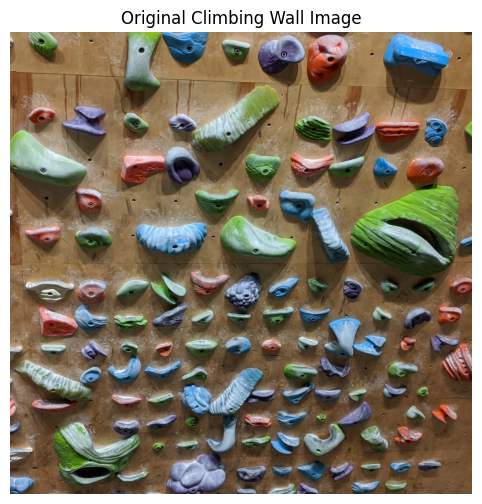

2. Extracting dominant colors...


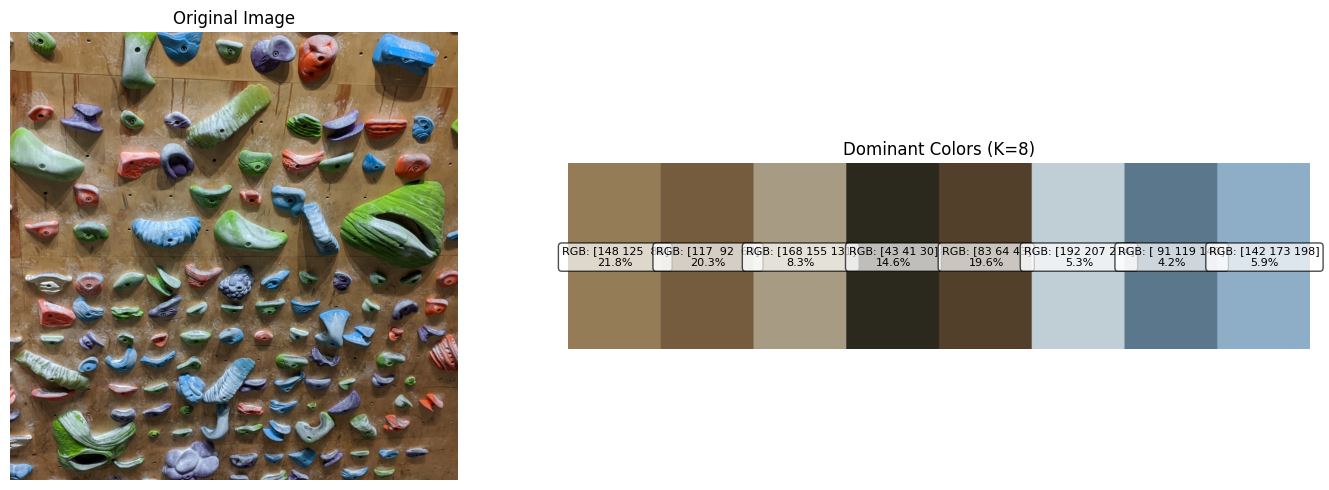

Choose colors from the palette above for hold segmentation
Common climbing hold colors to look for:
Color 1: RGB[255, 0, 0]
Color 2: RGB[0, 255, 0]
Color 3: RGB[0, 0, 255]
Color 4: RGB[255, 255, 0]
Color 5: RGB[255, 0, 255]
Color 6: RGB[0, 255, 255]
3. Segmenting holds by color...


C:\Users\0fore\AppData\Local\Temp\ipykernel_31368\1498037144.py:90: RuntimeWarning: overflow encountered in scalar subtract
  lower_bound = np.array([max(0, target_hsv[0] - tolerance//3), 50, 50])


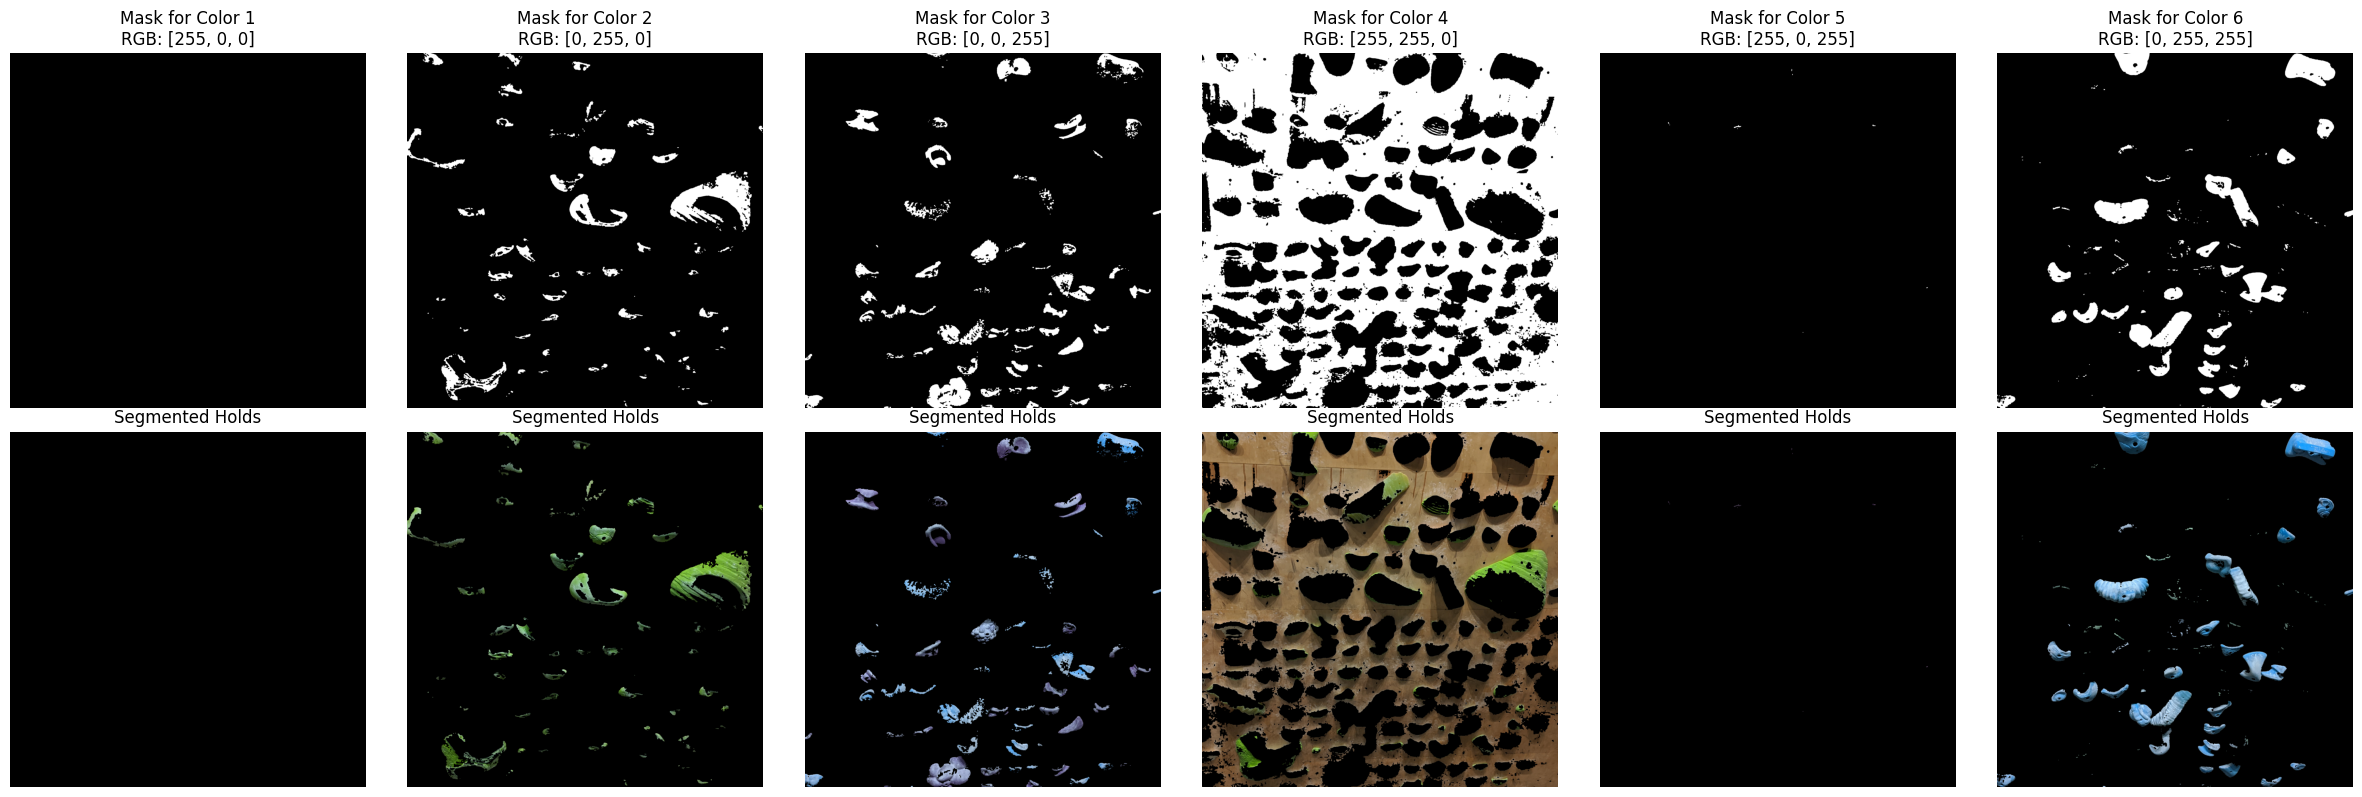

4. Detecting individual holds...


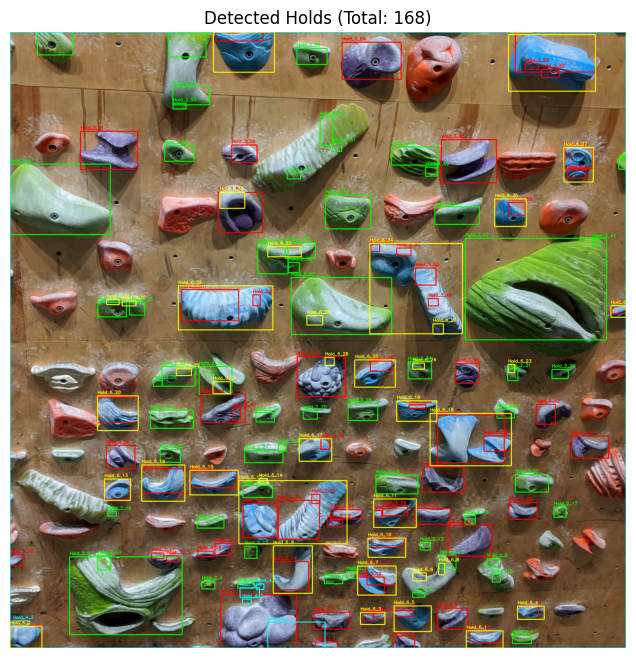


=== Results ===
Total holds detected: 168
Color Group 2, Hold 1: Center at (2513, 2982), Area: 1491 pixels
Color Group 2, Hold 2: Center at (2006, 2763), Area: 772 pixels
Color Group 2, Hold 3: Center at (1158, 2718), Area: 592 pixels
Color Group 2, Hold 4: Center at (973, 2715), Area: 1392 pixels
Color Group 2, Hold 5: Center at (1587, 2693), Area: 1712 pixels
Color Group 2, Hold 6: Center at (2387, 2681), Area: 816 pixels
Color Group 2, Hold 7: Center at (1677, 2665), Area: 1087 pixels
Color Group 2, Hold 8: Center at (2368, 2605), Area: 1166 pixels
Color Group 2, Hold 9: Center at (568, 2767), Area: 50392 pixels
Color Group 2, Hold 10: Center at (462, 2605), Area: 1546 pixels
Color Group 2, Hold 11: Center at (2149, 2602), Area: 2082 pixels
Color Group 2, Hold 12: Center at (1182, 2553), Area: 1978 pixels
Color Group 2, Hold 13: Center at (2038, 2523), Area: 1146 pixels
Color Group 2, Hold 14: Center at (984, 2415), Area: 1691 pixels
Color Group 2, Hold 15: Center at (2258, 2394), 

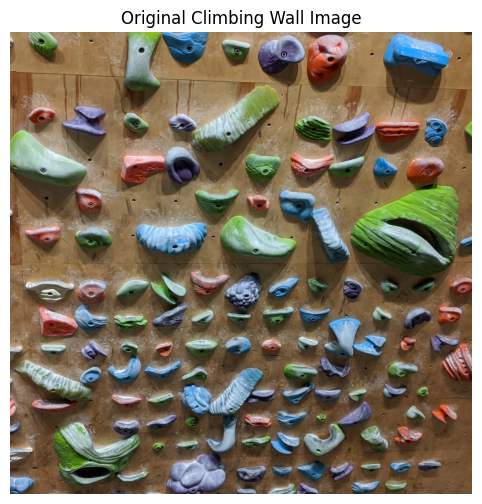

3. Segmenting holds by color...


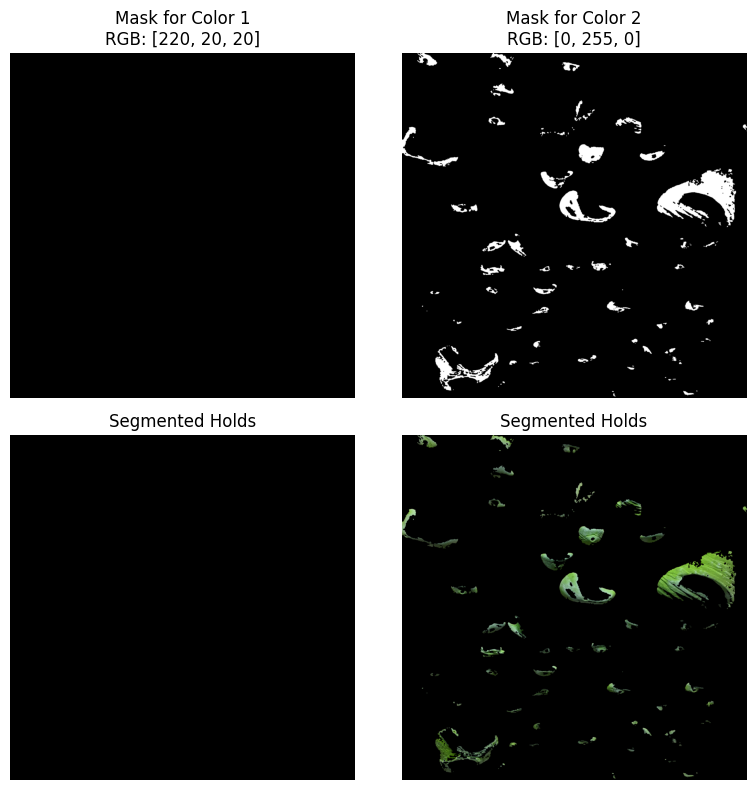

4. Detecting individual holds...


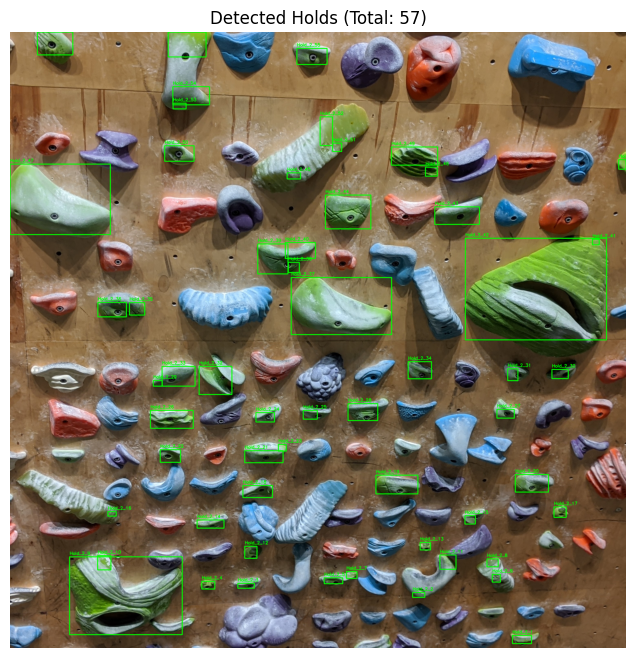


=== Results ===
Total holds detected: 57
Color Group 2, Hold 1: Center at (2513, 2982), Area: 1491 pixels
Color Group 2, Hold 2: Center at (2006, 2763), Area: 772 pixels
Color Group 2, Hold 3: Center at (1158, 2718), Area: 592 pixels
Color Group 2, Hold 4: Center at (973, 2715), Area: 1392 pixels
Color Group 2, Hold 5: Center at (1587, 2693), Area: 1712 pixels
Color Group 2, Hold 6: Center at (2387, 2681), Area: 816 pixels
Color Group 2, Hold 7: Center at (1677, 2665), Area: 1087 pixels
Color Group 2, Hold 8: Center at (2368, 2605), Area: 1166 pixels
Color Group 2, Hold 9: Center at (568, 2767), Area: 50392 pixels
Color Group 2, Hold 10: Center at (462, 2605), Area: 1546 pixels
Color Group 2, Hold 11: Center at (2149, 2602), Area: 2082 pixels
Color Group 2, Hold 12: Center at (1182, 2553), Area: 1978 pixels
Color Group 2, Hold 13: Center at (2038, 2523), Area: 1146 pixels
Color Group 2, Hold 14: Center at (984, 2415), Area: 1691 pixels
Color Group 2, Hold 15: Center at (2258, 2394), A

In [2]:
holds_info = analyze_climbing_wall('C:/Users/0fore/Downloads/test_wall.jpg')
custom_colors = [[220, 20, 20], [0, 255, 0]]
holds_info = analyze_climbing_wall('test_wall.jpg', target_colors=custom_colors)